# Implemententación del índice de calidad (ica)

En este notebook, se presenta el procedimiento utilizado para llevar a cabo la implementación del índice de disponibilidad basado en los criterios generados por Natalia.


In [1]:
# Librerías

# Manipulación y visualización de datos
import pandas as pd 
import geopandas as gpd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

# Warnings
import warnings

In [2]:
# Filter warinings
warnings.filterwarnings('ignore')

# Parameters of matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
matplotlib.rcParams['grid.color'] = 'k'
matplotlib.rcParams['grid.linestyle'] = '-'
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['figure.titlesize'] = 'large'
matplotlib.rcParams["font.family"] = "serif"

In [3]:
# Lectura de los datasets, con su descripción
data = pd.read_csv('./primary_dataset_v3.csv', index_col=0)
descr = pd.read_csv('./primary_dataset_v3_descr.csv', index_col=0)

In [4]:
# Obtain the parameters
ica_list = ['clave_monitoreo', 'latitud','longitud',
  'fluoruros_tot',
  'coli_fec',
  'n_no3',
  'as_tot',
  'hg_tot',
  'dur_tot',
  'std_ra',
  'mn_tot',
  'fe_tot'
 ]

# Non used parameters ): 
faltan = 'Cadmio','Cromo','Plomo'
calidad = data[ica_list]

In [5]:
# Individual weights
w = {"fluoruros_tot_coef":3,
     'coli_fec_coef':4,
     'n_no3_coef':3,
     'as_tot_coef':3,
     'hg_tot_coef':4,
     'dur_tot_coef':1,
     'std_ra_coef':2,
     'mn_tot_coef':1,
     'fe_tot_coef':1
    }

# Total weight
w_tot = sum(w.values())

def fluoruros_tot_coef(x):
    weight = w['fluoruros_tot_coef']/w_tot
    if 0.5 <= x < 0.9:
        q = 0
    elif x < 0.5 or 0.9 <= x < 1.5:
        q = 100
    elif x >= 1.5:
        q = 200
    return q*weight

    
def coli_fec_coef(x):
    weight = w['coli_fec_coef']/w_tot
    if x < 1:
        q = 0
    elif 1<= x < 5:
        q = 100
    elif 5<=x<20:
        q = 200
    elif x >=20:
        q = 100000
    return q*weight


def n_no3_coef(x):
    weight = w['n_no3_coef']/w_tot
    if x <= 5:
        q = 0
    elif 5 < x < 10:
        q = 100
    elif x >= 10:
        q = 200
    return q*weight

        
def as_tot_coef(x):
    weight = w['as_tot_coef']/w_tot
    if x <= 0.01:
        q = 0
    else:
        q = 10000
    return q*weight


def hg_tot_coef(x):
    weight = w['hg_tot_coef']/w_tot
    if x <= 0.006:
        q = 0
    else:
        q = 10000
    return q*weight


def dur_tot_coef(x):
    weight = w['dur_tot_coef']/w_tot
    if x < 100:
        q = 0
    elif 100 <= x < 500:
        q = 100
    elif x >= 500:
        q = 200
    return q*weight


def std_ra_coef(x):
    weight = w['std_ra_coef']/w_tot
    if x < 1000:
        q = 0
    elif 1000 <= x < 10000:
        q = 100
    elif x >= 10000:
        q = 200
    return q*weight


def mn_tot_coef(x):
    weight = w['mn_tot_coef']/w_tot
    if x <= 0.15:
        q = 0
    elif x > 0.15:
        q = 100
    return q*weight


def fe_tot_coef(x):
    weight = w['fe_tot_coef']/w_tot
    if x <= 0.3:
        q = 0
    elif x > 0.3:
        q = 100
    return q*weight

In [6]:
# Application of parameters
calidad['fluoruros_tot_coef'] = calidad['fluoruros_tot'].apply(fluoruros_tot_coef)
calidad['coli_fec_coef'] = calidad['coli_fec'].apply(coli_fec_coef)
calidad['n_no3_coef'] = calidad['n_no3'].apply(n_no3_coef)
calidad['as_tot_coef'] =  calidad['as_tot'].apply(as_tot_coef)
calidad['hg_tot_coef'] = calidad['hg_tot'].apply(hg_tot_coef)
calidad['dur_tot_coef'] = calidad['dur_tot'].apply(dur_tot_coef)
calidad['std_ra_coef'] = calidad['std_ra'].apply(std_ra_coef)
calidad['mn_tot_coef'] =  calidad['mn_tot'].apply(mn_tot_coef)
calidad['fe_tot_coef'] = calidad['fe_tot'].apply(fe_tot_coef)

In [7]:
# Coefficients
coef_list = [w for w in calidad.columns if "coef" in w]

calidad[coef_list]

# ICA coefficients
calidad['ICA'] = (100 -
                  calidad['fluoruros_tot_coef'] -
                  calidad['coli_fec_coef'] -
                  calidad['n_no3_coef'] -
                  calidad['as_tot_coef'] - 
                  calidad['hg_tot_coef'] -
                  calidad['dur_tot_coef'] -
                  calidad['std_ra_coef'] -
                  calidad['mn_tot_coef'] -
                  calidad['fe_tot_coef']) / 100
                  
calidad.loc[calidad['ICA']<=0,'ICA'] = 0

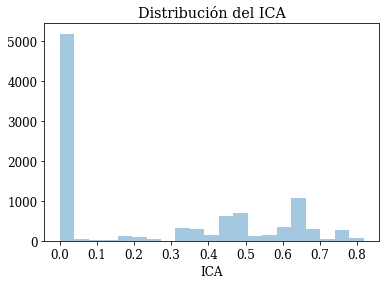

In [8]:
# ICA distribution
sns.distplot(calidad.ICA, bins=21, kde=False)
plt.title('Distribución del ICA')
plt.xlabel("ICA")
plt.show()

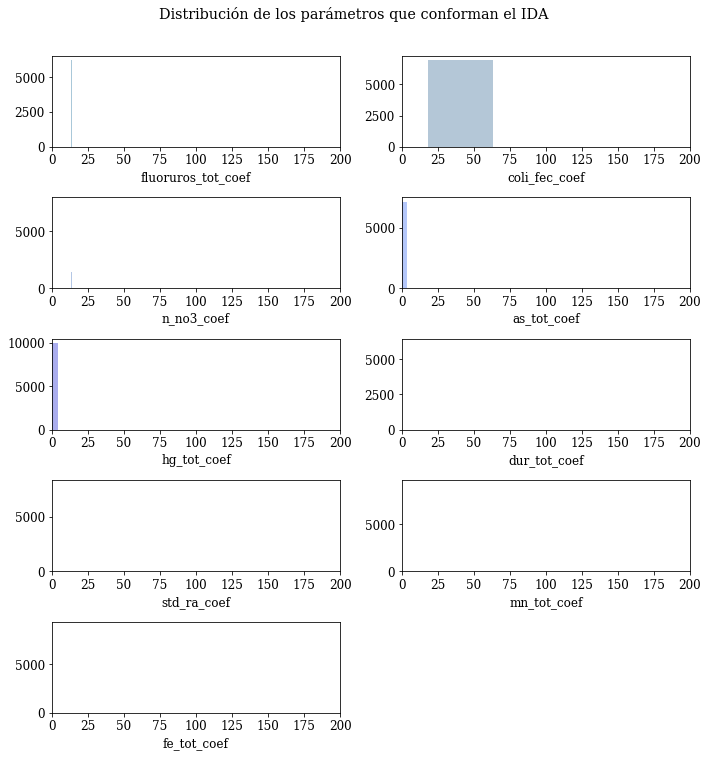

In [9]:
# Parameters distribution
colors = ['#2C77A2', '#45759D','#4575C0','#4575F3','#2C33D5','#2C77A2', '#45759D','#4575C0','#4575F3','#2C33D5']
plt.figure(figsize=(10,10))
for i,word in enumerate(coef_list):
    plt.subplot(5,2,i+1)
    sns.distplot(
        calidad[word],
        kde=False,
        color=colors[i],
        bins=400)
    plt.xlim(0,200)
    plt.suptitle("Distribución de los parámetros que conforman el IDA", y=1.05)
plt.tight_layout()

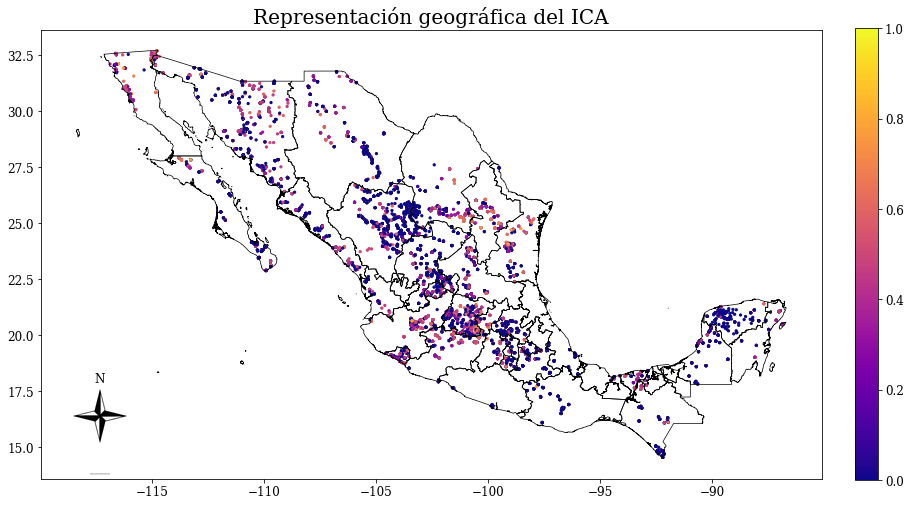

In [10]:
# Geographical representation
geo_data = gpd.read_file("./destdv250k_2gw.shx")
geo_data.boundary.plot(linewidth=.7, color="black", figsize=(15, 10))
sc = plt.scatter(calidad.longitud,
                 calidad.latitud, 
                 c=calidad.ICA, 
                 s=5, 
                 vmin=0.0, 
                 vmax=1.0,
                 cmap ='plasma')
im =  Image.open("./image-formats/rosa-de-vientos3.png")
im.thumbnail((120, 120), Image.ANTIALIAS)
plt.text(-117.55,17.9, "N",)
plt.figimage(im, 40, 30)
plt.colorbar(sc, fraction=0.027, pad=0.04)
plt.title("Representación geográfica del ICA", fontsize=20)
plt.show()

In [11]:
# Not wanted list
non_wanted_list = ['fluoruros_tot_coef',
                   'coli_fec_coef',
                   'n_no3_coef',
                   'as_tot_coef',
                   'hg_tot_coef',
                   'dur_tot_coef',
                   'std_ra_coef',
                   'mn_tot_coef',
                   'fe_tot_coef'                   
                  ] + ica_list[1:]

data2 = data.merge(calidad.drop(non_wanted_list, axis=1),
                   on='clave_monitoreo')
data2

,clave_monitoreo,clave_sitio,nombre_sitio,organismo_cuenca,estado,municipio,cuerpo_agua,tipo_cuerpo_agua,subtipo_cuerpo_agua,año,...,daily_precip_intensity_max_time,daily_precip_type,daily_pressure,daily_summary,daily_wind_gust,daily_wind_gust_time,ozone,wind_gust,IDA,ICA
0,dlagu19-021212,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2012,...,1.355499e+09,NaN,1015.634444,NaN,NaN,1.355844e+09,240.885556,NaN,0.33,0.681818
1,dlagu19-260513,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2013,...,1.371001e+09,NaN,1006.926667,NaN,NaN,1.369195e+09,243.524444,NaN,0.33,0.727273
2,dlagu19-270714,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2014,...,1.404127e+09,NaN,1014.604444,NaN,NaN,1.405455e+09,242.664444,NaN,0.33,0.000000
3,dlagu19-190415,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2015,...,1.431031e+09,NaN,1012.682222,NaN,NaN,1.429337e+09,243.055556,NaN,0.33,0.772727
4,dlagu19-140216,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2016,...,1.457445e+09,NaN,1020.975556,NaN,NaN,1.456508e+09,245.844444,NaN,0.33,0.772727
5,dlagu19-090717,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2017,...,1.498432e+09,NaN,1013.722222,NaN,NaN,1.499877e+09,241.582222,NaN,0.33,0.590909
6,dlagu19-110318,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2018,...,1.520013e+09,NaN,1012.618889,NaN,NaN,1.520438e+09,242.156667,NaN,0.33,0.000000
7,dlagu19-021218,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2018,...,1.543381e+09,rain,1018.000000,Despejado durante el día.,3.76,1.543381e+09,237.000000,2.65,0.33,0.000000
8,dlagu19-160619,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2019,...,1.560308e+09,rain,1017.800000,Parcialmente nublado durante el día.,14.30,1.560234e+09,278.500000,3.61,0.33,0.590909
9,dlagu1m1-251112,dlagu1m1,pozo de la comunidad de los duron,lerma santiago pacífico,aguascalientes,aguascalientes,acuífero el llano,subterráneo,pozo,2012,...,1.355292e+09,NaN,1014.454444,NaN,NaN,1.355326e+09,240.106667,NaN,0.33,0.545455


In [12]:
# Dataset without columns
data2.drop(ica_list[3:], axis=1).to_csv('./primary_dataset_v4.csv')

In [13]:
# Description without non desired items:
descr[~descr.CLAVE.isin(ica_list[3:])].to_csv('./primary_dataset_v4_descr.csv')